In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
from configs import Prometheus, Prometheus_launch_conditions
import constants as con
from rocketpy import Environment, Flight, Rocket, SolidMotor

## RocketPy Simulation


### Environment


Define the `Environment` object


In [2]:
# Environment conditions
env = Environment(
    latitude=32.99028,
    longitude=-106.96972,
    date=(2022, 6, 24, 13),
    elevation=1401
)
# may want to add wind
env.set_atmospheric_model(
    type="standard_atmosphere" #TBU
)

Visualize the `Environment` object



Gravity Details

Acceleration of gravity at surface level:    9.7913 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5534 m/s²


Launch Site Details

Launch Date: 2022-06-24 13:00:00 UTC
Launch Site Latitude: 32.99028°
Launch Site Longitude: -106.96972°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315961.92 W    3651932.28 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1401.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 80.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 855.92 hPa
Surface Temperature: 279.06 K
Surface Air Density: 1.068 kg/m³
Surface Speed of Sound: 334.54 m/s


Earth Model Details

Earth Radius at Launch site: 6371.83 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



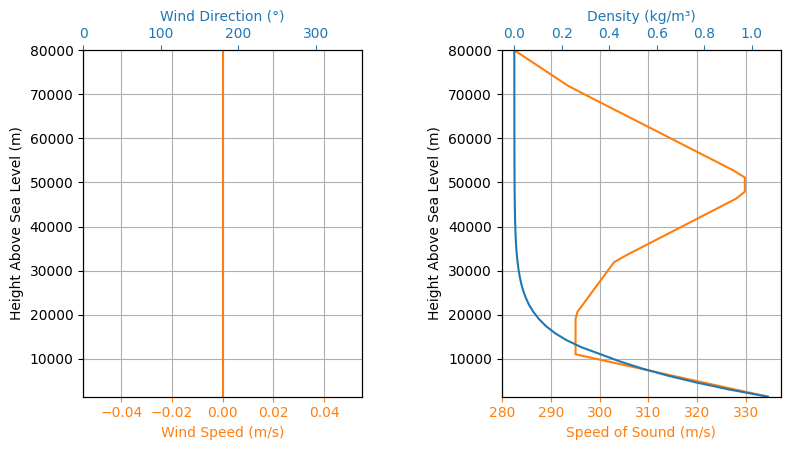

In [3]:
env.info()

### Motor


Define the `SolidMotor` object


In [4]:
thrust_dict = Prometheus.motor.thrust_curve
def thrust_curve(t):
    time_list = list(thrust_dict.keys())
    thrust_list = list(thrust_dict.values())
    if t < time_list[0]:
        return thrust_list[0]
    elif t > time_list[-1]:
        return 0
    else:
        return np.interp(t, time_list, thrust_list)

# rocket: nose_to_tail
motot_M1520 = SolidMotor(
    thrust_source=thrust_curve,
    burn_time=Prometheus.motor.burn_time,
    dry_mass=Prometheus.motor.dry_mass,
    dry_inertia=(0, 0, 0),
    center_of_dry_mass_position=-0.35,#TBU
    grains_center_of_mass_position=-0.35,#TBU

    grain_number=1,#TBU, just picked to give correct mass
    grain_separation=0,#TBU
    grain_density=2420,#TBU, just picked to give correct mass
    grain_outer_radius=0.033,#TBU
    grain_initial_inner_radius=0.015,#TBU
    grain_initial_height=0.57,#TBU, just picked to give correct mass

    nozzle_radius=0.02475,#TBU
    interpolation_method="linear", # the default
    coordinate_system_orientation="combustion_chamber_to_nozzle", #TBU
)

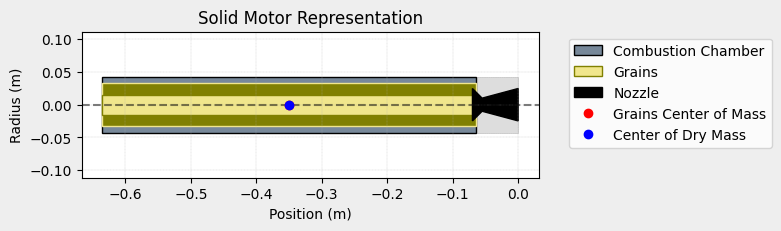

Nozzle Details
Nozzle Radius: 0.02475 m
Nozzle Throat Radius: 0.01 m

Grain Details
Number of Grains: 1
Grain Spacing: 0 m
Grain Density: 2420 kg/m3
Grain Outer Radius: 0.033 m
Grain Inner Radius: 0.015 m
Grain Height: 0.57 m
Grain Volume: 0.002 m3
Grain Mass: 3.744 kg

Motor Details
Total Burning Time: 4.897 s
Total Propellant Mass: 3.744 kg
Average Propellant Exhaust Velocity: 2013.514 m/s
Average Thrust: 1539.495 N
Maximum Thrust: 1821.9999786750636 N at 1.6989591836734694 s after ignition.
Total Impulse: 7538.907 Ns



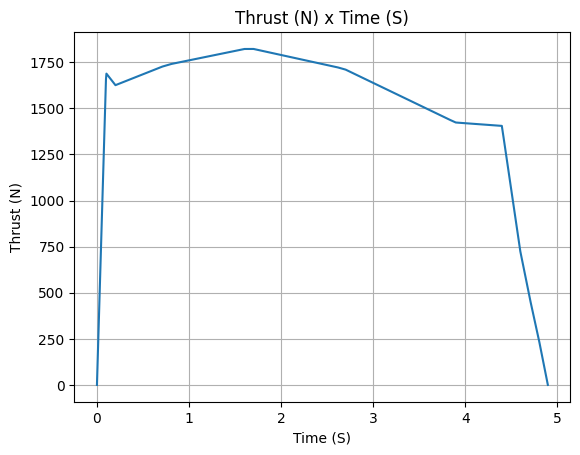

In [5]:
motot_M1520.plots.draw()
motot_M1520.info()

### Rocket


Create the `Rocket` object


In [6]:
# TBU rough translation of Cd(Re) into a Cd(mach) function
# assumptions:
air_temp_for_mach = 20 + 273.15 # assumed constant at 20C (temp about halfway through flight)
dynamic_viscosity_for_mach = 1.85e-5 # assumed constant at 1.85e-5 (dynamic viscosity at 20C)
air_density_for_mach = 0.85 # assumed constant at 0.85 kg/m^3 (air density about halfway through flight)
# mach = speed / np.sqrt(1.4 * con.R_specific_air * temp)
# Re = air_density * speed * len_characteristic / dynamic_viscosity
# Re = air_density * mach * len_characteristic / (dynamic_viscosity * np.sqrt(1.4 * con.R_specific_air * temp))
Cd_at_Re = Prometheus.Cd_rocket_at_Re

def Cd_at_mach(mach):
    Re = air_density_for_mach * mach * Prometheus.L_rocket / (dynamic_viscosity_for_mach * np.sqrt(1.4 * con.R_specific_air * air_temp_for_mach))
    return Cd_at_Re(Re)


Prometheus_RP = Rocket(
    radius = 0.06985, # 5.5" diameter circle
    mass = Prometheus.rocket_mass,
    inertia=(#TBU
        73.316,#TBU
        73.316,#TBU
        0.15982,#TBU
    ),
    power_off_drag=Cd_at_mach,#TBU
    power_on_drag=Cd_at_mach,#TBU
    center_of_mass_without_motor=1.3,#TBU
    coordinate_system_orientation="nose_to_tail",
)

Prometheus_RP.set_rail_buttons(1.5, 2, 45)#TBU

Prometheus_RP.add_motor(motor=motot_M1520, position=3.391)#TBU

Adding aerodynamic surfaces


In [7]:
nose_cone = Prometheus_RP.add_nose(
    length=0.742, # measure and update
    kind="Von Karman",
    position=0
)

fin_set = Prometheus_RP.add_trapezoidal_fins(
    3,
    span=0.14, # measure and update
    root_chord=0.331, # measure and update
    tip_chord=0.1395, # measure and update
    position=3.05,#TBU
    sweep_angle=13,#TBU
    radius=0.0775, # "transition bottom radius" #TBU
)

Adding Parachute


In [8]:
drogue = Prometheus_RP.add_parachute(
    "Drogue",
    cd_s=1.6*np.pi*0.61**2, # TBU
    trigger="apogee",
)
main = Prometheus_RP.add_parachute(
    "Main",
    cd_s=2.2*np.pi*1.22**2, # TBU
    trigger=457.2, # 1500 ft
)

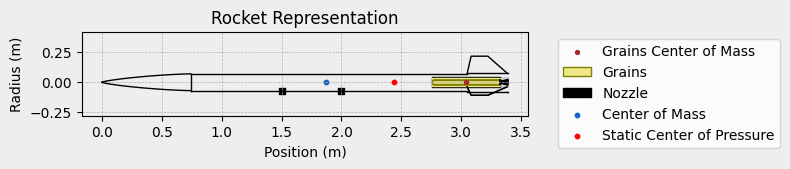

In [9]:
Prometheus_RP.draw()

In [10]:
Prometheus_RP.info()


Inertia Details

Rocket Mass: 13.930 kg (without motor)
Rocket Dry Mass: 16.911 kg (with unloaded motor)
Rocket Loaded Mass: 20.655 kg (with loaded motor)
Rocket Inertia (with unloaded motor) 11: 80.759 kg*m2
Rocket Inertia (with unloaded motor) 22: 80.759 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.160 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.06985 m
Rocket Frontal Area: 0.015328 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.307 m
Rocket Center of Dry Mass - Nozzle Exit: 1.784 m
Rocket Center of Dry Mass - Center of Propellant Mass: 1.434 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.260 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 6.051/rad

Center of Pressure

Nose Cone Center

### Flight


In [11]:
# Flight
flight = Flight(
    rocket=Prometheus_RP,
    environment = env,
    rail_length = Prometheus_launch_conditions.L_launch_rail,
    inclination = Prometheus_launch_conditions.launch_angle,
    terminate_on_apogee=True,
)


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 1401.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.704 | e1: -0.062 | e2: 0.062 | e3: -0.704
Euler Angles - Spin φ : 0.00° | Nutation θ: -10.00° | Precession ψ: -90.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 5.18  m
Launch Rail Inclination: 80.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.359 s
Rail Departure Velocity: 21.484 m/s
Rail Departure Stability Margin: 4.220 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 8.281
Rail Departure Reynolds Number: 1.840e+05


Burn out State

Burn out time: 4.897 s
Altitude at burn out: 851.670 m (AGL)
Rocket velocity at burn out: 317.677 m/s
Freestream velocity at burn out: 317.677 m/s
Mach Number at burn out: 0.960
Kinetic energy at burn

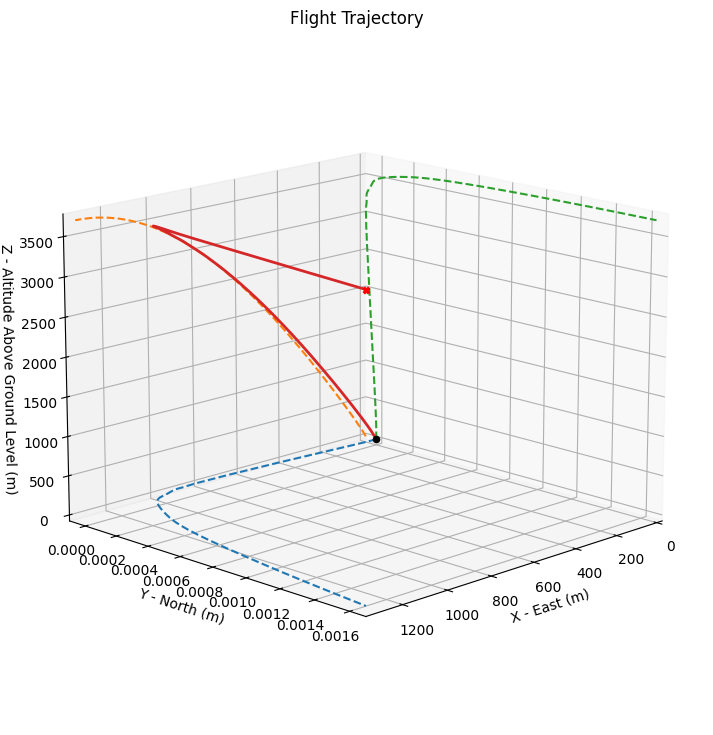

In [12]:
flight.info()
flight.plots.trajectory_3d()